# Data generator

This is a copy of `utils.py` to understand and possibly polish for readability.

This [blog][blog] seems to be the source from where the author wrote the custom data generator.

Check the [tensorflow][tf] explanation and related links.



[tf]: https://www.tensorflow.org/guide/keras/train_and_evaluate
[blog]: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
import sys # to load custom python code
sys.path.append('D:\\Tesis\\Source')
from patchProcessAssemble import Normalize
from visualize import vol

In [4]:
def view(img):
    
    n1, n2, n3 = np.shape(img)
    
    plt.figure(1,figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("n1/n2")
    plt.imshow(img[:,:,n3//2],origin="upper", cmap="bone")
    plt.subplot(1,3,2)
    plt.title("n1/n3")
    plt.imshow(img[:,n2//2,:],origin="upper",cmap="bone")
    plt.subplot(1,3,3)
    plt.title("n2/n3")
    plt.imshow(img[n1//2,:,:],origin="upper",cmap="bone")
    plt.show()

    return None

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self,dpath,fpath,data_IDs, batch_size=1, dim=(128,128,128), 
                 n_channels=1, shuffle=True):
        'Initialization'
        self.dim   = dim
        self.dpath = dpath
        self.fpath = fpath
        self.batch_size = batch_size
        self.data_IDs   = data_IDs
        self.n_channels = n_channels
        self.shuffle    = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_IDs)/self.batch_size))

    def __getitem__(self, index):
        'Generates one batch of data'
        # Generate indexes of the batch
        bsize   = self.batch_size
        indexes = self.indexes[index*bsize:(index+1)*bsize]

        # Find list of IDs
        data_IDs_temp = [self.data_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(data_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_IDs))
        if self.shuffle == True:
              np.random.shuffle(self.indexes)

    def __data_generation(self, data_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        # JLG: data stream is read:
        gx  = np.fromfile(self.dpath+str(data_IDs_temp[0])+'.dat',dtype=np.single)
        fx  = np.fromfile(self.fpath+str(data_IDs_temp[0])+'.dat',dtype=np.single)
        # JLG: data is shaped into a cube
        gx = np.reshape(gx,self.dim)
        fx = np.reshape(fx,self.dim)
        # JLG: why this normalization was applied and discarded?
        #gmin = np.min(gx)
        #gmax = np.max(gx)
        #gx = gx-gmin
        #gx = gx/(gmax-gmin)
        #gx = gx*255
        # JLG: data is whitened (normalized):
#       xm = np.mean(gx)
#       xs = np.std(gx)
#       gx = gx-xm
#       gx = gx/xs
        gx = Normalize(gx)
        # JLG: data is transposed to conform with (time,x,y); meaning that the original input is (x,y,time).
        gx = np.transpose(gx)
        fx = np.transpose(fx)
        #in seismic processing, the dimensions of a seismic array is often arranged as
        #a[n3][n2][n1] where n1 represnts the vertical dimenstion. This is why we need 
        #to transpose the array here in python 
        # Generate data
        X = np.zeros((2, *self.dim, self.n_channels),dtype=np.single) # JLG: e.g., X is (2,128x128x128,1)
        Y = np.zeros((2, *self.dim, self.n_channels),dtype=np.single)
        X[0,] = np.reshape(gx, (*self.dim,self.n_channels))  # JLG: the original `image`
        Y[0,] = np.reshape(fx, (*self.dim,self.n_channels))  
        X[1,] = np.reshape(np.flipud(gx), (*self.dim,self.n_channels)) # JLG: upside down
        Y[1,] = np.reshape(np.flipud(fx), (*self.dim,self.n_channels))  
        ## JLG: the following should go with
        # X = np.zeros((4, *self.dim, self.n_channels),dtype=np.single) 
        # Y = np.zeros((4, *self.dim, self.n_channels),dtype=np.single)
        '''
        for i in range(4):
            X[i,] = np.reshape(np.rot90(gx,i,(2,1)), (*self.dim,self.n_channels))
            Y[i,] = np.reshape(np.rot90(fx,i,(2,1)), (*self.dim,self.n_channels))  
        '''
        return X,Y

### Checking the custom data generator

In [6]:
# Parameters

seismPathT = "D:\\Tesis\\faultSeg-master\\data\\train\\seis\\"
faultPathT = "D:\\Tesis\\faultSeg-master\\data\\train\\fault\\"

params = {'batch_size':1,
          'dim':(128,128,128),
          'n_channels':1,
          'shuffle': True}


# Take 10 synthetic cubes and 10 fault probabilities "    
train_ID   = range(10) 

In [7]:
train_generator = DataGenerator(dpath    = seismPathT,
                                fpath    = faultPathT,
                                data_IDs = train_ID,
                                **params)

In [8]:
# Take one item of the dataset (one item is one batch)
X, Y  = train_generator.__getitem__(0)
print(X.shape)
print(Y.shape)

(2, 128, 128, 128, 1)
(2, 128, 128, 128, 1)


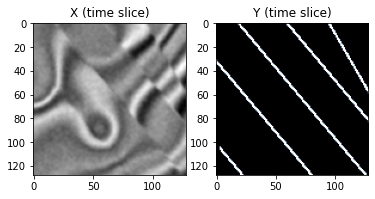

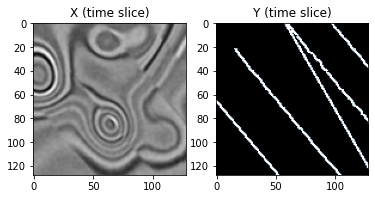

In [9]:
# Visualize mini batch (one "item" of the data generator)
for i in np.arange(X.shape[0]):
    plt.figure()
    plt.subplot(1,2,1)
    plt.title("X (time slice)")
    plt.imshow(X[i,0,:,:,-1],cmap="gray")
    plt.subplot(1,2,2)
    plt.title("Y (time slice)")
    plt.imshow(Y[i,0,:,:,-1],cmap="bone")
    plt.show()

In [12]:
# Visualize 3D
fig=plt.figure()
vol(X[i,...,0])
fig.savefig("D:\\Tesis\\cubo1.pdf", bbox_inches='tight')

fig2=plt.figure()

vol(Y[i,...,0])
fig2.savefig("D:\\Tesis\\cubofallas.pdf", bbox_inches='tight')

plt.show()


SyntaxError: invalid syntax (<ipython-input-12-0ce37970689a>, line 4)

**Example**. The seismic  cube `gx` is `128x128x128` samples and its data tensor `X` is `(2,128x128x128,1)` when the effective batch size is `2` and there is `1`  channel. 

### Notes

* Note that the batch size is given by `batch_size=1` in `training.py`, but the autor creates 2 or 4 samples if rotations are applied as **data augmentation**:

        We feed the 3D seismic images to the neural network in batches
        and each batch contains four images, which consist of an
        original image and the same image rotated
        around the vertical time/depth axis by 90°, 180°, and 270°


* In the last lines of the above cell (61-end) we see the author only uses one rotation, given by `np.flipud`. This is flipping the first dimension of the array (see `? np.flipud`), which is the vertical dimension (time or depth) after transposition. This is like `gx[::-1,...]`, meaning the cube is turned upside down.

* `np.rot90(gx,i,axes=(2,1))` rotates by 90 degrees a number of `i` times in the plane defined by the axes (2,1), which should be the  inline/crossline or x-y plane. The rotation is  from the first axis (here, `2`) towards the second axis (here, `1`) ; see `?np.rot90`.

In [ ]:
#?np.flipud

In [ ]:
#?np.rot90

In [ ]:
# class imbalance:
minibatch_size, n1, n2, n3, channels, = np.shape(X)
total_samples = n1*n2*n3
fault_samples = np.sum(Y,dtype="int") # np.count_nonzero(Y)
fault_percentage = np.round(100. * fault_samples / total_samples,1)
print("Number of samples of one cube: ", total_samples)
print("Number of fault samples (val=1) of one cube: ", fault_samples)
print("Percentage of fault samples over total samples: ", fault_percentage)
print("Percentage of non fault samples over total samples: ", 100. - fault_percentage)

### Example of reading  one data sample

In [ ]:
n1,n2,n3   = 128,128,128
n_channels = 1

In [ ]:
gx = np.fromfile("D:\\Tesis\\faultSeg-master\\data\\train\\seis\\0.dat",dtype=np.single); # If dtype is not np.single, I cannot reshape into n1xn2xn3
print("data read (with type single) from file  has shape:", gx.shape)
gx = np.reshape(gx, (n1,n2,n3));
print("reshaped data is:", gx.shape, ", that is ", n1*n2*n3, " samples.") 

In [ ]:
view(gx)
print("data seems to be (x,y,z)")
view(np.transpose(gx))
print("transposed data seems to be (z,y,x)")

Let's see the data tensor `X`:

In [ ]:
# Generate data
# Normalize the data and bring vertical dimension first
gx  = Normalize(gx)
gxt = np.transpose(gx)
# Get space for batch:
X = np.zeros((2, n1,n2,n3, n_channels),dtype=np.single) # JLG: e.g., X is (2,128x128x128,1)
# Populate batch:
X[0,] = np.reshape(gxt, (n1,n2,n3,n_channels))  # JLG: the original `image`
X[1,] = np.reshape(np.flipud(gxt), (n1,n2,n3,n_channels)) # JLG: upside down
print("Batch tensor is: ",X.shape)
for i in range(2):
    #view(X[i,].squeeze())  # squeeze gets rid of the dimension of channels = 1
    # this is similar to
    view(X[i,...,-1])

In [ ]:
# 3D View:
plt.figure()
for i in range(X.shape[0]):
    vol(X[i,...,0].T) # .T to put the time axis in the vertical for display
plt.show()

Test **data augmentation** (original data plus three 90 degree rotations around the vertical axis):

In [ ]:
X = np.zeros((4, n1,n2,n3, n_channels),dtype=np.single) 


In [ ]:
np.shape(X)

In [ ]:
X = np.zeros((4, n1,n2,n3, n_channels),dtype=np.single) 

print("Batch tensor is: ",X.shape)

for i in range(4):
    X[i,] = np.reshape(np.rot90(gxt,i,(2,1)), (n1,n2,n3,n_channels))
        
# View:
for i in range(4):
    view(X[i,...,0])

In [ ]:
# 3D View:
plt.figure()
for i in range(X.shape[0]):
    vol(X[i,...,0].T) # .T to put the time axis in the vertical for display
plt.show()

# Extra: Class imbalance

The number of fault samples in each training cube is - on average - only 7% of the total.

In [ ]:
filename = range(200)
fpath    = faultPathT

In [ ]:
fault_percentage = []
for name in filename:
    file = fpath+str(filename[name])+'.dat'
    #print(file)
    fx  = np.fromfile(file,dtype=np.single)    
    fault_percentage.append(np.count_nonzero(fx))
print("Done.")
fault_percentage = np.array(fault_percentage)
fault_percentage = 100 * fault_percentage / (n1*n2*n3)

In [ ]:
print("Average of fault samples in the training set (percentage): ", np.round(np.mean(fault_percentage),2))
print("Median of fault samples in the training set (percentage) : ", np.round(np.median(fault_percentage),2))

In [ ]:
avrg=np.round(np.mean(fault_percentage),2)
nonfault=100-avrg
etiquetas=["No Fallas","Fallas"]
valores=[nonfault,avrg]
plt.bar(etiquetas,valores,color="green")
plt.ylim([0,100])
plt.ylabel("Porcentaje de pixeles, Set Entrenamiento")
plt.savefig("D:\\Tesis\\Bibliografia\\Tesis_Imagenes\\classimbalanced2.jpg")

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.bar(filename,fault_percentage,color="gray")
plt.plot([np.mean(fault_percentage)]*len(filename),color="orange",alpha=0.4,lw=4)
plt.plot([np.median(fault_percentage)]*len(filename),color="red",alpha=0.4,lw=4)
plt.ylabel("Fault samples / total (training) [%]")
plt.xlabel("Example #")
#fig.savefig("D:\\Tesis\\Notebooks_JLG\\checkpoints\\classimbalanced.pdf",bbox_inches='tight')
plt.show()

# A custom iterator for using a custom training loop


If we choose to use `tensorflow` with our custom training loop and data generator, we can simplify things a lot. 

In [ ]:
# def Normalize(x):
#     # see tf.image.per_image_standardization
#     N      = len(x)
#     mean   = np.mean(x)
#     stddev = np.std(x)
#     stddev = np.maximum(stddev, 1.0/np.sqrt(N)) # protect againts division by zero
#     return (x - mean) / stddev # 

In [ ]:
def DataGeneration(filename,dim=(128,128,128),n_channels=1):    
        
        'Generates data containing batch_size samples'
        # Initialization
        # JLG: data stream is read:
        print(x_path+str(filename)+'.dat')
        print(y_path+str(filename)+'.dat')
        
        gx  = np.fromfile(x_path+str(filename)+'.dat',dtype=np.single)
        fx  = np.fromfile(y_path+str(filename)+'.dat',dtype=np.single)
        
        # JLG: data is whitened (normalized):
        gx = Normalize(gx)
        
        # JLG: data is shaped into a cube
        gx = np.reshape(gx,dim)
        fx = np.reshape(fx,dim)
        
        # JLG: data is transposed to conform with (time,x,y); meaning that the original input is (x,y,time).
        gx = np.transpose(gx)
        fx = np.transpose(fx)
        
        # Generate data augmentation 
        X = np.zeros((2, *dim, n_channels),dtype=np.single) # JLG: e.g., X is (2,128x128x128,1)
        Y = np.zeros((2, *dim, n_channels),dtype=np.single)
        X[0,] = np.reshape(gx, (*dim,n_channels))  # JLG: the original `image`
        Y[0,] = np.reshape(fx, (*dim,n_channels))  
        X[1,] = np.reshape(np.flipud(gx), (*dim,n_channels)) # JLG: upside down
        Y[1,] = np.reshape(np.flipud(fx), (*dim,n_channels))
        #print(X.shape)
        return [X,Y]

In [ ]:
params = {'batch_size':3,
          'dim':(128,128,128),
          'n_channels':1,
          'shuffle': True}

x_path = "../data/train/seis/"
y_path = "../data/train/fault/"


# Take 10 synthetic cubes and 10 fault probabilities "    
filenames   = np.arange(200) 
np.random.shuffle(filenames)
filenames   = filenames[:10]

In [ ]:
filenames

In [ ]:
bsize   = params["batch_size"]

# Generate data
#np.random.shuffle(filenames)

for epoch in range(2):
    np.random.shuffle(filenames)
    print("Epoch:",epoch)
    print("batch of files:",filenames)
    for k in range(10//bsize):    
        indexes = filenames[k*bsize:(k+1)*bsize]
        print("minibatch",k,"=> Files: ",indexes)
        for indx in indexes:
            X, Y = DataGeneration(indx)
    
    

A custom training loop:

In [ ]:
# Custom training loop
N_train = 10
EPOCHS  = 2
batch_size = params["batch_size"]

# Take N_train synthetic cubes and its N_train fault probabilities "    
filenames   = np.arange(200) 
np.random.shuffle(filenames)
filenames   = filenames[:N_train]

batch_list = filenames

loss_value = 0.
for epoch in range(EPOCHS):
    
    print("This is epoch %d/%d =========================="
          %(epoch+1,EPOCHS))
    
    np.random.shuffle(batch_list) # in-place shuffling
    
    print("Feeding order: %s"  
          %(batch_list))  # In case you want to see which samples are given.
    
    #for step,index in enumerate(batch_list):
        ##x_batch_train, y_batch_train = train_dataset.__getitem__(index=index)
        #x_batch_train, y_batch_train = DataGeneration(index)
        
    number_of_minibatches = range(len(batch_list)//bsize)
    print("Number of minibatches:",len(number_of_minibatches)) 
    
    for step,index in enumerate(number_of_minibatches):    
        indexes = batch_list[index*bsize:(index+1)*bsize]
        print("minibatch",step+1,"=> Files: ",indexes)
        for indx in indexes:
            X, Y = DataGeneration(indx)
        
            # Here compute loss and the gradient of weights        
            print("Forward and backward propagation ...")
            print("Optimizing weights.")    


            # Log every some batches.        
            if step % 10 == 0:
                        print(
                        "Training loss (for one batch) at step %d: %.4f"
                         % (step, float(loss_value)))

print("Done.")

# Dataset with list files and zip

References: [zip][ZIP], [shuffle][SHUFFLE].


[SHUFFLE]: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
[ZIP]: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip

In [ ]:
# Mirar esto para más adelante:
# Genera Dataset con la lista de archivos y elijo algunos para ver:
list_seis  = tf.data.Dataset.list_files(str("../data/train/seis/*.dat"),shuffle=True).batch(1)
for file in list_seis.take(1):  # only take one at random from the list
    print(file)
    print(file.numpy()[0]) # fist element of list
    seis_file  = file.numpy()[0]
    gx = np.fromfile(seis_file,dtype=np.single)    
    gx = np.reshape(gx,(128,128,128))   
    vol(gx,cmap="bone")
    plt.show()       

In [ ]:
# Make a dataset of files from two directories:
list_seis   = tf.data.Dataset.list_files(str("../data/train/seis/*.dat"),shuffle=False).batch(1)
list_fault  = tf.data.Dataset.list_files(str("../data/train/fault/*.dat"),shuffle=False).batch(1)
dataset     = tf.data.Dataset.zip((list_seis, list_fault))
nfile       = len(list_seis)
dataset     = dataset.shuffle(buffer_size=nfile, seed=None, reshuffle_each_iteration=None)

In [ ]:
assert len(list_seis) == len(list_fault)

In [ ]:
# Try a loop with some examples:
for x,y in dataset.take(3):
    print("X:",x.numpy())
    print("Y:",y.numpy()) 
    seis_file  = x.numpy()[0] # fist element of list
    fault_file = y.numpy()[0]
    X = np.fromfile(seis_file ,dtype=np.single)    
    Y = np.fromfile(fault_file,dtype=np.single)
    X = np.reshape(X,(128,128,128))   
    Y = np.reshape(Y,(128,128,128))
    vol(X,cmap="gray");
    plt.show()      
    vol(Y,cmap="bone");
    plt.show()       

# Misc.

[Reference][pytorch-dataloader]

[pytorch-dataloader]: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
import os

root="../data/train/"

seis_files  = list(sorted(os.listdir(os.path.join(root, "seis"))))
fault_files = list(sorted(os.listdir(os.path.join(root, "fault"))))

print("Found {} files.".format(len(seis_files)))
print("Found {} files.".format(len(fault_files)))

In [ ]:
np.random.shuffle(seis_files) # in-place shuffling    

In [ ]:
for file in seis_files[:2]: # check first 2
    print(file)
    path_to_file = root+"seis/"+file
    print(path_to_file)
    print("-------")    
    X = np.fromfile(path_to_file ,dtype=np.single)
    Y = np.fromfile(root+"fault/"+file ,dtype=np.single)
    X = np.reshape(X,(128,128,128))
    Y = np.reshape(Y,(128,128,128))   
    vol(X,cmap="gray");
    plt.show()      
    vol(Y,cmap="gray");
    plt.show()      
        

In [ ]:
# files = zip(seis_files,fault_files)
# print(list(files))